/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


2 [1 3]
2 [1 3]
4 [3 5]
4 [3 5]
5 [4 6]
4 [3 5]
5 [4 6]
3 [2 4]
8 [7 9]
10 [ 9 11]
12.0 True


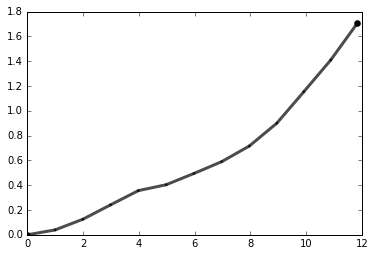

In [4]:
import numpy as np
import shapely.geometry as shg
import matplotlib.pyplot as plt
import copy as cp
import scipy.spatial.distance as scd


%matplotlib inline
plt.ion()




COLOR = {
    True:  'black',
    False: '#ffcc33'
    }

def v_color(ob):
    return COLOR[ob.is_simple]

def plot_tree(ax,ob):
    #for line in ob:
    #    x, y = line.xy
    #    ax.plot(x, y, 'o', color='#999999', zorder=1)
        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)
    
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, color=v_color(ob), alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

#no of interations
iterations = 10

max = 5
parent_id = 1
node_idx = 1
inter_pts = 7
prev_ang = 0
r = np.linspace(.99,.26,inter_pts)

min_dist = .5

#stack initial point

segments = []
segments_term = [np.array([0.,0])]

#expander node

expander = 1

#child to parent mapping

chp = {}

#parent to child mapping

pch = {}

#node angle

pang = {}

pang[0] = 0


def get_segment(rot,r=1):
    start_pt = np.array([1., 0])
    R = r*np.array([
                    [ np.cos(rot*np.pi/180), -np.sin(rot*np.pi/180)],
                    [ np.sin(rot*np.pi/180), np.cos(rot*np.pi/180)]
                ])
    return np.dot(R,start_pt)

#flatten list

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

#get subtree

def get_subtree(par_to_ch,node_no):
    if node_no not in par_to_ch.keys():
        return node_no
    else:
        chn = par_to_ch[node_no]
        return [node_no] + flatten([get_st(par_to_ch,node) for node in chn])

def path_to_root(ch_to_par,node_no):
    if node_no not in ch_to_par.keys():
        return 0
    else:
        return [node_no] + flatten([path_to_root(ch_to_par,ch_to_par[node_no])])
    


#initialization of tree
# first segment

ang = (np.random.random()*(-2*max)+max) + prev_ang
new_segt = segments_term[expander-1], (segments_term[expander-1] + get_segment(ang))
test_line = shg.LineString(new_segt)
prev_ang = prev_ang + ang
segments.append( shg.LineString(cp.copy(new_segt)) )
segments_term.append(new_segt[1])

expander += 1

node_idx += 1

#update dicts

chp[expander] = expander - 1

pch[expander - 1] = (expander,)


#second segment

ang = (np.random.random()*(-2*max)+max) + prev_ang
new_segt = segments_term[expander-1], (segments_term[expander-1] + get_segment(ang))
test_line = shg.LineString(new_segt)
segments.append( shg.LineString(cp.copy(new_segt)) )
segments_term.append(new_segt[1])
delayed_tree = shg.MultiLineString(segments[:-1])

expander += 1

node_idx += 1

chp[expander] = expander - 1

pch[expander - 1] = (expander,)

for k in np.arange(iterations):
    
    parent_id = chp[expander]
    
    
    #build tree
    
    delayed_tree = shg.MultiLineString(segments[:-1])
    
    #set this just in case
    
    hammerTime = True
    counter = 0
    
    #add next segment
    #draw angle and length
    
    ang = (np.random.random()*(-2*max)+max) + prev_ang
    new_segt = segments_term[parent_id], (segments_term[parent_id] + get_segment(ang))
    
    #check if there is no intersection
    
    test_line = shg.LineString(new_segt)
    dist = delayed_tree.distance(test_line)
    
    #if no then add segment
    
    if dist > min_dist:
        prev_ang = ang
        segments.append( shg.LineString(cp.copy(new_segt)) )
        segments_term.append(cp.copy(new_segt[1]))
        tree = shg.MultiLineString(segments)
        
        expander += 1
        node_idx += 1
        
        chp[expander] = expander - 1
        try:
            pch[expander - 1] = pch[expander - 1] + (expander,)
        except:
            pch[expander - 1] = (expander,)
    #else try another one
    else:
        counter = 0
        while counter < 10 and hammerTime:
            ang = (np.random.random()*(-2*max)+max) + prev_ang
            new_segt = segments_term[ parent_id ], (segments_term[ parent_id ] + get_segment(ang))
            test_line = shg.LineString(new_segt)
            dist = delayed_tree.distance(test_line)
            if dist > min_dist:
                prev_ang = ang
                segments.append( shg.LineString(cp.copy(new_segt)) )
                segments_term.append(cp.copy(new_segt[1]))
                tree = shg.MultiLineString(segments)
                delayed_tree = shg.MultiLineString(segments[:-1])
                
                expander += 1
                node_idx += 1
                
                hammerTime = False
                
                chp[expander] = expander - 1
                
                try:
                    pch[expander - 1] = pch[expander - 1] + (expander,)
                except:
                    pch[expander - 1] = (expander,)  
                    
            counter += 1
    
    #draw from existing nodes node to branch
    node = np.random.choice(np.arange(2,node_idx-1))
    #get all immediate neighbours of the node
    
    parent_id = chp[node]
    
    try:
        children = pch[node]
    except:
        children = []
        
    #print node,'parent_id',parent_id, '\nother children plus node', pch[parent_id], '\n children of the node ', pch[node], '\n'
    
    
    neigh = np.setdiff1d([ parent_id ] + list(pch[parent_id]) + list(pch[node]),[node])

    print node, neigh
    
    

    
    #neigh_subtrees = [[segments_term[item] for item in get_st(pch,neigh)] for neigh in all_neigh]
    
    #print neigh_subtrees
    
    #not_neighbours = [ segments_term[n_idx] for n_idx in np.arange(node_idx-1) if n_idx not in (children + (parent_id,))]
    #print node, '\nsegments_term', segments_term, '\n', 'parent' , segments_term[parent_id],'\n nn ', not_neighbours, '\n\n'
    #delayed_tree = shg.MultiLineString(not_neighbours)
    
    #expand at node
    '''
    counter = 0
    hammerTime = True
    
    while counter < 30 and hammerTime:
        ang = (np.random.random()*(-2*max)+max) 
        new_segt = segments_term[ parent_id ], (segments_term[ parent_id ] + 4*get_segment(ang))
        test_line = shg.LineString(new_segt)
        dist = delayed_tree.distance(test_line)
        if dist > min_dist:
            prev_ang = ang
            segments.append( shg.LineString(cp.copy(new_segt)) )
            segments_term.append(cp.copy(new_segt[1]))
            delayed_tree = shg.MultiLineString(segments[:-1])
                
            node_idx += 1
                
            hammerTime = False
                
            chp[node_idx] = node
                
            try:
                pch[node] = pch[node] + (node_idx,)
            except:
                pch[node] = (node_idx,)  
                    
        counter += 1
    '''

print tree.length, tree.is_simple

#plot
plot_tree(plt, tree)
plt.draw()
